# SLS Sentinel 10m TC

Kode modelling klasifikasi densenet dan resnet IDM pada data sentinel 2 10m dengan neighbor True crop, input tingkat SLS.

In [1]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

### SLS Dataset Review

In [49]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\AppData\Local\Temp\ipykernel_11944\701159028.py:1: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")


In [51]:
sls.iddesa.unique().shape

(5957,)

In [52]:
idm = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/newdata_edit.csv")

In [53]:
sls_new = sls.set_index("iddesa").join(idm.set_index("bps_kelurahan_kode"), how ="left", rsuffix = "idm")

In [54]:
sls_new["iddesa"] = sls_new.index
sls_new["bps_kelurahan_kode"] = sls_new.index

In [55]:
sls_new.shape

(222861, 97)

In [56]:
sls_new = sls_new.drop_duplicates(["idsls"])

In [57]:
sls_new.shape

(219919, 97)

#### Preprocessing

In [58]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general sls sentinel 10m tc/"
destpath = 'C:/Users/jwst2/Python/tesis/jpg/IDM/04. SLS Sentinel 10m TC'

In [59]:
os.chdir('C:/Users/jwst2/Python/tesis/jpg/IDM/04. SLS Sentinel 10m TC')
if os.path.isdir('jabar_idm/MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')

In [60]:
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        if(not sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].empty):
            if(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "MAJU"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "BERKEMBANG"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "TERTINGGAL"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "MANDIRI"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
       

1it [06:49, 409.92s/it]


In [61]:
test_path = 'C:/Users/jwst2/Python/tesis/jpg/IDM/test sls 10m TC/'

In [62]:
split = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/test_idm.csv")

In [64]:
split_test = split

In [65]:
os.chdir(test_path)
if os.path.isdir('jabar_idm/MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')

In [66]:
catlist = ["MAJU MANDIRI","TERTINGGAL BERKEMBANG"]

In [71]:
destpath + catlist[0]

'C:/Users/jwst2/Python/tesis/jpg/IDM/04. SLS Sentinel 10m TCMAJU MANDIRI'

In [73]:
for i in range(0,2):
    catlist[i]
    yourpath = destpath +"/"+ catlist[i]
    for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
        for name in files:
            try :
                if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                    shutil.move(os.path.join(root, name), test_path+catlist[i]+"/"+name)
            except Exception:
                print(name)
                pass 

1it [00:43, 43.96s/it]
1it [00:58, 58.92s/it]


### Run Dataset

In [74]:
path = Path.cwd() / (destpath)

In [75]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('MAJU MANDIRI'),Path('TERTINGGAL BERKEMBANG')]

In [78]:
fname = (path/"MAJU MANDIRI").ls()[0]
fname

Path('MAJU MANDIRI/32010200010001.jpg')

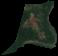

In [79]:
img = Image.open(fname)
img

In [80]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label,
                 item_tfms = Resize(64)) # data augmentation (mult multiplies the default transformation values)

In [81]:
dls = blocks.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


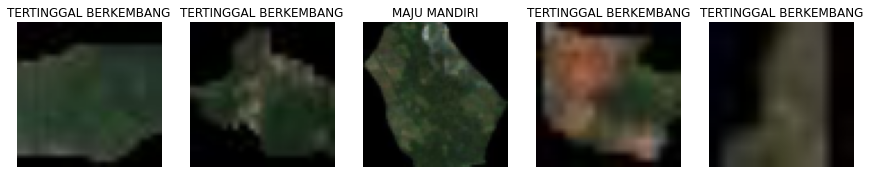

In [82]:
dls.show_batch(nrows=1, ncols=5)

In [83]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0005754399462603033)

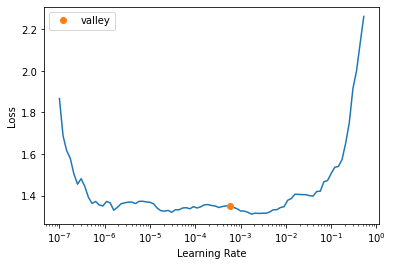

In [84]:
learn.lr_find()

In [86]:
learn.unfreeze()

In [87]:
learn.fit_one_cycle(5,lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.742555,12.330772,0.586387,0.562585,0.569618,0.562585,0.559816,0.580878,18:29
1,0.668352,0.726193,0.610778,0.568407,0.605432,0.568407,0.547270,0.600442,11:12
2,0.654588,0.754988,0.625335,0.599324,0.614407,0.599324,0.596749,0.644454,11:14
3,0.649459,0.644385,0.633827,0.608708,0.624145,0.608708,0.606958,0.661771,11:21
4,0.644884,0.641578,0.635934,0.606820,0.628618,0.606820,0.602825,0.662865,11:37


In [88]:
dls.vocab

['MAJU MANDIRI', 'TERTINGGAL BERKEMBANG']

In [90]:
dls.train.items[1500]

Path('MAJU MANDIRI/32022600040001.jpg')

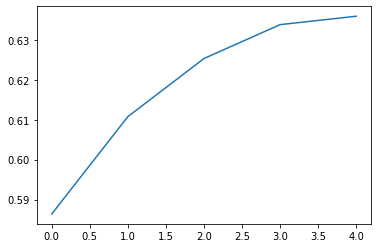

In [91]:
plt.plot(L(learn.recorder.values).itemgot(2));

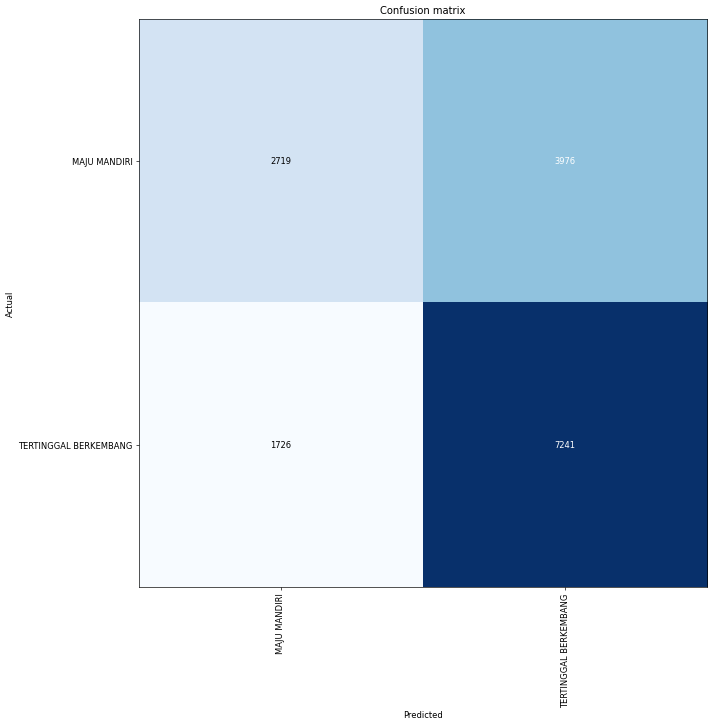

In [92]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(3, figsize=(20,11))

In [ ]:
learn.export('C:/Users/jwst2/Python/tesis/models/SLS Densenet Sentinel TC.pkl')

### Up level

In [94]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if('TERTINGGAL BERKEMBANG' in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [98]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [99]:
pd.value_counts(true_label)

1    80020
0    60939
dtype: int64

In [100]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.349360,0.650640,32072500030033,1.0,3207250003
1,0.432595,0.567405,32081610040011,1.0,3208161004
2,0.239882,0.760118,32040400060032,1.0,3204040006
3,0.359214,0.640786,32101800020001,1.0,3210180002
4,0.316612,0.683388,32020200020025,1.0,3202020002


In [101]:
pd.value_counts(df.stat)

1.0    100778
0.0     40181
Name: stat, dtype: int64

In [102]:
df["true_lab"] = true_label

In [103]:
pd.value_counts(df.true_lab)

1    80020
0    60939
Name: true_lab, dtype: int64

In [104]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.6363055924063026

In [105]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.349360,0.650640,32072500030033,1.0,3207250003,0
1,0.432595,0.567405,32081610040011,1.0,3208161004,1
2,0.239882,0.760118,32040400060032,1.0,3204040006,0
3,0.359214,0.640786,32101800020001,1.0,3210180002,1
4,0.316612,0.683388,32020200020025,1.0,3202020002,0


In [204]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [205]:
desa_pred.columns = ["pred","true"]

In [206]:
pd.value_counts(df.stat)

1.0    100778
0.0     40181
Name: stat, dtype: int64

In [207]:
for i in np.arange(0.0, 0.95, 0.05):
    value = round(i,3)
    desa_pred["label"+str(value)] = 0
    desa_pred.loc[desa_pred.pred >value,"label"+str(value)] = 1

In [208]:
desa_pred.head()

,pred,true,label0.0,label0.05,label0.1,label0.15,label0.2,label0.25,label0.3,label0.35,...,label0.45,label0.5,label0.55,label0.6,label0.65,label0.7,label0.75,label0.8,label0.85,label0.9
iddesa,,,,,,,,,,,,,,,,,,,,,
3201010001,1.000000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010002,1.000000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010003,1.000000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010004,0.893617,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
3201010005,0.916667,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [209]:
for j in range(2,19):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.0
accuracy : 0.6400334658021335
precision : 0.6400920694706005
result label0.05
accuracy : 0.6410792721188036
precision : 0.6409987410826689
result label0.1
accuracy : 0.6473541100188245
precision : 0.6454891994917408
result label0.15
accuracy : 0.6515373352855052
precision : 0.6486774744027304
result label0.2
accuracy : 0.6596946245555323
precision : 0.6547850507669043
result label0.25
accuracy : 0.6676427525622255
precision : 0.6610466389314649
result label0.3
accuracy : 0.6734992679355783
precision : 0.6671125975473802
result label0.35
accuracy : 0.678100815728927
precision : 0.672566371681416
result label0.4
accuracy : 0.6824932022589416
precision : 0.6788033395176253
result label0.45
accuracy : 0.6852122986822841
precision : 0.6845478281509613
result label0.5
accuracy : 0.6841664923656139
precision : 0.6901373895976447
result label0.55
accuracy : 0.6856306212089521
precision : 0.6976389946686976
result label0.6
accuracy : 0.6873039113156243
precision : 0.707614751923

In [210]:
from sklearn.metrics import confusion_matrix

In [211]:
pd.value_counts(desa_pred.true)

1.0    3060
0.0    1721
Name: true, dtype: int64

### Test result

In [212]:
path_pred = Path.cwd() / (test_path)
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [213]:
len(test_files)

17856

In [214]:
test_dl = learn.dls.test_dl(test_files)

In [215]:
preds,_ = learn.get_preds(dl  =test_dl)

In [216]:
str(test_files[1])[-18:-4]

'32010200170002'

In [217]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("TERTINGGAL BERKEMBANG" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [218]:
test = pd.DataFrame(preds)

In [219]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [220]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [221]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.289672,0.710328,32010200170001,0,3201020017,1.0
1,0.271979,0.728021,32010200170002,0,3201020017,1.0
2,0.387918,0.612082,32010200170003,0,3201020017,1.0
3,0.591971,0.408029,32010200170004,0,3201020017,0.0
4,0.500880,0.499120,32010200170005,0,3201020017,0.0


In [222]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [223]:
desa_pred_test

,stat,true_lab
,mean,mean
iddesa,,
3201010011,0.861111,1.0
3201020002,0.885714,1.0
3201020017,0.325581,0.0
3201030009,0.897959,1.0
3201040009,0.937500,1.0
...,...,...
3218090012,0.965517,1.0
3218100001,0.920000,1.0


In [224]:
desa_pred_test.columns = ["pred","true"]

In [227]:
desa_pred_test["pred_lab"] = 0
desa_pred_test.loc[desa_pred_test.pred > 0.65,"pred_lab"] = 1

In [228]:
desa_pred_test

,pred,true,pred_lab
iddesa,,,
3201010011,0.861111,1.0,1
3201020002,0.885714,1.0,1
3201020017,0.325581,0.0,0
3201030009,0.897959,1.0,1
3201040009,0.937500,1.0,1
...,...,...,...
3218090012,0.965517,1.0,1
3218100001,0.920000,1.0,1
3218100004,0.946429,1.0,1


In [229]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.6949152542372882
balanced_accuracy_score : 0.6284900284900284
precision : 0.7380352644836272
recall : 0.8347578347578347
f1 : 0.783422459893048
rocauc : 0.6284900284900284


### Resnet

In [233]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

SuggestedLRs(valley=0.015848932787775993)

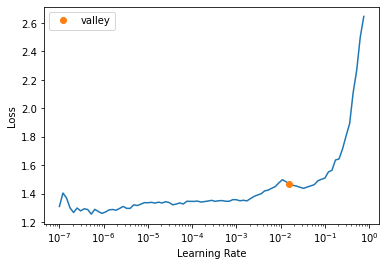

In [234]:
learn_rs.lr_find()

In [236]:
learn_rs.unfreeze()

In [237]:
learn_rs.fit_one_cycle(5,lr_max= 1e-1)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.985753,0.701602,0.427468,0.500000,0.213734,0.500000,0.299459,0.450321,08:36
1,0.808411,0.695905,0.572468,0.499944,0.286252,0.499944,0.364057,0.557889,08:38
2,0.746195,0.776079,0.525540,0.505964,0.506304,0.505964,0.504011,0.516938,08:41
3,0.674233,0.663509,0.618886,0.573710,0.623356,0.573710,0.548578,0.646105,08:38
4,0.646550,0.643868,0.637658,0.608874,0.630545,0.608874,0.605196,0.659090,08:45


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [238]:
learn_rs.fit_one_cycle(3,lr_max= 1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.657098,0.649799,0.635551,0.602398,0.631374,0.602398,0.595143,0.656789,08:23
1,0.656177,0.649048,0.629166,0.617675,0.619635,0.617675,0.618288,0.659587,08:29
2,0.639401,1.876374,0.637466,0.608518,0.630415,0.608518,0.604719,0.661772,08:29


In [239]:
learn_rs.export('C:/Users/jwst2/Python/tesis/models/SLS resnet sentinel TC.pkl')

In [240]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if("TERTINGGAL BERKEMBANG" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [241]:
preds,_ = learn_rs.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [243]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.340104,0.659896,32072500030033,1.0,3207250003
1,0.413670,0.586330,32081610040011,1.0,3208161004
2,0.269375,0.730625,32040400060032,1.0,3204040006
3,0.363604,0.636396,32101800020001,1.0,3210180002
4,0.318792,0.681208,32020200020025,1.0,3202020002


In [244]:
pd.value_counts(df.stat)

1.0    101123
0.0     39836
Name: stat, dtype: int64

In [245]:
df["true_lab"] = true_label

In [246]:
pd.value_counts(df.true_lab)

1    80020
0    60939
Name: true_lab, dtype: int64

In [247]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.6364687604196965

In [248]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.340104,0.659896,32072500030033,1.0,3207250003,0
1,0.413670,0.586330,32081610040011,1.0,3208161004,1
2,0.269375,0.730625,32040400060032,1.0,3204040006,0
3,0.363604,0.636396,32101800020001,1.0,3210180002,1
4,0.318792,0.681208,32020200020025,1.0,3202020002,0


In [249]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [250]:
desa_pred.columns = ["pred","true"]

In [251]:
pd.value_counts(df.stat)

1.0    101123
0.0     39836
Name: stat, dtype: int64

In [252]:
for i in np.arange(0.1, 0.95, 0.05):
    value = round(i,2)
    desa_pred["label"+str(value)] = 0
    desa_pred.loc[desa_pred.pred > value,"label"+str(value)] = 1

In [254]:
desa_pred

,pred,true,label0.1,label0.15,label0.2,label0.25,label0.3,label0.35,label0.4,label0.45,label0.5,label0.55,label0.6,label0.65,label0.7,label0.75,label0.8,label0.85,label0.9
iddesa,,,,,,,,,,,,,,,,,,,
3201010001,1.000000,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3201010002,1.000000,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3201010003,0.974359,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3201010004,0.978723,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3201010005,0.916667,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279030007,0.964286,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3279040001,0.857143,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
3279040003,0.920000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [255]:
for j in range(2,19):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.1
accuracy : 0.6465174649654883
precision : 0.6450042337002541
result label0.15
accuracy : 0.6523739803388412
precision : 0.6490405117270789
result label0.2
accuracy : 0.6590671407655302
precision : 0.6544276457883369
result label0.25
accuracy : 0.6676427525622255
precision : 0.6611878150339688
result label0.3
accuracy : 0.6728717841455762
precision : 0.6665182546749777
result label0.35
accuracy : 0.6768458481489228
precision : 0.6714964908308807
result label0.4
accuracy : 0.6785191382555951
precision : 0.6763139615651771
result label0.45
accuracy : 0.6799832670989333
precision : 0.6811937470393179
result label0.5
accuracy : 0.6829115247856097
precision : 0.6890303623898139
result label0.55
accuracy : 0.6837481698389458
precision : 0.6953558808682484
result label0.6
accuracy : 0.6839573311022799
precision : 0.7036550092032606
result label0.65
accuracy : 0.6829115247856097
precision : 0.7131419105466593
result label0.7
accuracy : 0.6827023635222756
precision : 0.7272459499

### Test result resnet

In [271]:
path_pred = Path.cwd() / (test_path)
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [272]:
test_dl = learn_rs.dls.test_dl(test_files)

In [273]:
preds,_ = learn_rs.get_preds(dl  =test_dl)

In [283]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("TERTINGGAL BERKEMBANG" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [284]:
test = pd.DataFrame(preds)

In [285]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [286]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [287]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.257203,0.742797,32010200170001,0,3201020017,1.0
1,0.261105,0.738895,32010200170002,0,3201020017,1.0
2,0.349903,0.650097,32010200170003,0,3201020017,1.0
3,0.586659,0.413341,32010200170004,0,3201020017,0.0
4,0.464386,0.535614,32010200170005,0,3201020017,1.0


In [288]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [289]:
desa_pred_test.columns = ["pred","true"]

In [290]:
desa_pred_test["pred_lab"] = 0
desa_pred_test.loc[desa_pred_test.pred > 0.7,"pred_lab"] = 1

In [291]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.6817325800376648
balanced_accuracy_score : 0.6306980056980057
precision : 0.7446236559139785
recall : 0.7891737891737892
f1 : 0.7662517289073305
rocauc : 0.6306980056980057


In [292]:
accuracy : 0.6817325800376648
balanced_accuracy_score : 0.6306980056980057
precision : 0.7446236559139785
recall : 0.7891737891737892
f1 : 0.7662517289073305
rocauc : 0.6306980056980057